In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

In [2]:
sortedFeatureCorr = pd.read_csv("dataset/corr.csv")
data = pd.read_csv("dataset/preprocessed.csv")


In [4]:
best_feature_count = 11
worst_feature_count = 10

In [5]:
a = sortedFeatureCorr.iloc[:, 0].values

In [6]:
for i in range(best_feature_count, sortedFeatureCorr.shape[0] - worst_feature_count):
    data = data.drop(a[i], axis = 1)

data = data.drop(list(data.columns)[0], axis = 1)

In [7]:
data_npWNan = data.iloc[:, :].values

tempNp = data_npWNan[data_npWNan[:, -1] != -1]
data_np = tempNp[:-2, :]
unique_elements, counts_elements = np.unique(data_np[:, -1], return_counts=True)
print("Frequency of unique values of the said array:")
print(np.asarray((unique_elements, counts_elements)))

print("feature " + str(data_np.shape))

Frequency of unique values of the said array:
[[     1      2      3      4      5]
 [ 78815  87257 136412 183844 275764]]
(762092, 21)
feature (762092, 21)


In [8]:
def kd_tree(data, counter, arr):
    if counter == 1:
        arr.append(data)
    if counter > 0:
        covarr = data[:-1].var(axis = 0)
        maxelement = covarr.argmax(axis = 0) 
        data = data[data[:, maxelement].argsort()]
        half = int(len(data) / 2)
        print(data[0])
        print(data.shape)
        print("max covariance feature index " + str(maxelement) + " half value " + str(half))
        kd_tree(data[: half], counter - 1, arr)
        kd_tree(data[half :], counter - 1, arr)
    
kdTreeArr = []
kd_tree(data_np, 3, kdTreeArr)

[ 2  2 70  0  0  0  1  0  0  1  0  1  0  0  1  0  0  1  0  1  4]
(762092, 21)
max covarıance feature ındex 2 ve half degerı 381046
[ 2  2 70  0  0  0  1  0  0  1  0  1  0  0  1  0  0  1  0  1  4]
(381046, 21)
max covarıance feature ındex 2 ve half degerı 190523
[ 2  2 70  0  0  0  1  0  0  1  0  1  0  0  1  0  0  1  0  1  4]
(190523, 21)
max covarıance feature ındex 2 ve half degerı 95261
[  2   2 280   1   0   0   0   0   0   0   1   1   0   0   1   0   0   1
   0   1   4]
(190523, 21)
max covarıance feature ındex 2 ve half degerı 95261
[  2   1 358   0   0   1   0   0   0   0   1   0   1   0   0   0   1   0
   0   1   2]
(381046, 21)
max covarıance feature ındex 2 ve half degerı 190523
[  2   1 358   0   0   1   0   0   0   0   1   0   1   0   0   0   1   0
   0   1   2]
(190523, 21)
max covarıance feature ındex 2 ve half degerı 95261
[  3   6 470   1   0   0   0   0   0   0   1   0   0   0   1   0   0   1
   0   1   5]
(190523, 21)
max covarıance feature ındex 2 ve half degerı 95261

In [10]:
from torch import nn

class Network(nn.Module):
    def __init__(self):
        super().__init__()        
        # Inputs to hidden layer linear transformation 
        self.output = nn.Linear(best_feature_count + worst_feature_count - 1, 121934) 
    def forward(self, x):
        x = self.output(x)
        return x

In [11]:
knn = Network()
knn = knn.cuda()

In [12]:
def normalize_encodings(encodings):
    ref_norms = np.linalg.norm(encodings, axis=0)
    return encodings / ref_norms

In [13]:
def select_k(similarity_mat, k_neighbour, train_label, true_label):
    truePred = 0
    for houseIndex in range(len(similarity_mat)):
        vote = train_label[similarity_mat[houseIndex][-1 * k_neighbour:]]
        pred = np.bincount(vote).argmax()
        if true_label[houseIndex] == pred:
            truePred += 1
    accur = truePred / len(true_label)
    return accur

In [14]:
def similarity(X_test):
    X_test = X_test.astype('float32')
    X_test = torch.from_numpy(X_test)
    X_test = X_test.cuda()
    out = knn(X_test)
    del X_test
    return out


In [15]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import gc 

cvCount = 10
numberOfKTry = 10
accuracyCount = np.array([0.0] * numberOfKTry)
startK = 770
kUpgrade = 2
batchSize = 50
maxKCount = startK + numberOfKTry * kUpgrade

    
kdPartCount = 0
for kdTreePart in kdTreeArr:  # 4 tane
    kdPartCount +=1
    feature = kdTreePart[:, :-1]
    target = kdTreePart[:, -1]

    #part 0
    X_trainAndVal, X_test, y_trainAndVal, y_test = train_test_split(feature, target, test_size = 0.2, random_state = 0)
    
    # Feature Scaling
    sc = StandardScaler()
    
    cvCounter = 0
    for cv in range(cvCount):  # 10 tane
        cvCounter += 1        
        
        X_train, X_val, y_train, y_val = train_test_split(X_trainAndVal, y_trainAndVal, test_size = 0.2, random_state = 0)
        X_train = sc.fit_transform(X_train) 
        X_val = sc.transform(X_val)
        X_train = normalize_encodings(X_train)
        knn.weight = X_train.T
        
        len_val = len(X_val) // batchSize + 1
        val_index = 0
        
        batchCount = 0
        
        for i in range(batchSize):  # 50 tane
            print(kdPartCount," bu kd parttasin",cvCounter, " bu cv desin ",batchCount, " bu batchtesin")
            batchCount +=1 
            
            
            xValBatch = X_val[val_index : val_index + len_val]
            yValBatch = y_val[val_index : val_index + len_val]
            out = similarity(xValBatch)
            
            index = 0
            out = out.cpu().detach().numpy()
            
            similarityMat = np.argpartition(out, -1 * maxKCount, axis = 1)[:, -1 * maxKCount:]
    
            for x in range(len(similarityMat)):       
                similarityMat[x] = similarityMat[x][np.argsort(out[x][similarityMat[x]])]
            
            for kTry in range(startK, numberOfKTry * kUpgrade + startK, kUpgrade):
                delta = select_k(similarityMat, kTry, y_train, yValBatch)
                accuracyCount[index] += delta
                index += 1
            val_index += len_val
            del out, xValBatch, yValBatch
            torch.cuda.empty_cache()
            gc.collect()
            
        del X_train, X_val, y_train, y_val
        gc.collect()
        
    del X_trainAndVal, X_test, y_trainAndVal, y_test
    gc.collect()



1  bu kd parttasin 1  bu cv desin  0  bu batchtesin
1  bu kd parttasin 1  bu cv desin  1  bu batchtesin
1  bu kd parttasin 1  bu cv desin  2  bu batchtesin
1  bu kd parttasin 1  bu cv desin  3  bu batchtesin
1  bu kd parttasin 1  bu cv desin  4  bu batchtesin
1  bu kd parttasin 1  bu cv desin  5  bu batchtesin
1  bu kd parttasin 1  bu cv desin  6  bu batchtesin
1  bu kd parttasin 1  bu cv desin  7  bu batchtesin
1  bu kd parttasin 1  bu cv desin  8  bu batchtesin
1  bu kd parttasin 1  bu cv desin  9  bu batchtesin
1  bu kd parttasin 1  bu cv desin  10  bu batchtesin
1  bu kd parttasin 1  bu cv desin  11  bu batchtesin
1  bu kd parttasin 1  bu cv desin  12  bu batchtesin
1  bu kd parttasin 1  bu cv desin  13  bu batchtesin
1  bu kd parttasin 1  bu cv desin  14  bu batchtesin
1  bu kd parttasin 1  bu cv desin  15  bu batchtesin
1  bu kd parttasin 1  bu cv desin  16  bu batchtesin
1  bu kd parttasin 1  bu cv desin  17  bu batchtesin
1  bu kd parttasin 1  bu cv desin  18  bu batchtesin
1  

In [17]:
accuracyCount /= (cvCount  * len(kdTreeArr) * batchSize)
bestKIndex = accuracyCount.argmax(axis=0) 
bestK = startK + bestKIndex * kUpgrade
print("en iyi k degeri ",bestK)

en iyi k degeri  784


In [18]:
print(accuracyCount)


[0.36222708 0.36221888 0.36221069 0.36221888 0.36222708 0.36221888
 0.36221888 0.36223528 0.36223528 0.36222708]


In [19]:
kNumber = []
for kTry in range(startK, numberOfKTry * kUpgrade + startK, kUpgrade):
    print(kTry)
    kNumber.append(kTry)

770
772
774
776
778
780
782
784
786
788


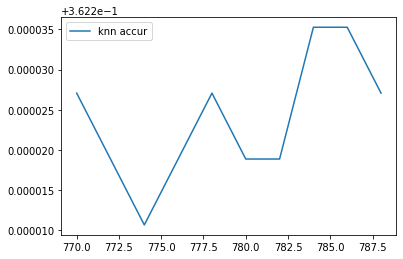

In [20]:
plt.plot(kNumber, accuracyCount, label = 'knn accur')

plt.legend()
plt.show()
